<a href="https://colab.research.google.com/github/rafiq8k-moga/Gemini-AI-Subtitle-Translator/blob/main/Subtitle_ass_Translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Mulai UI
!pip install -q gradio google-generativeai

import gradio as gr
import google.generativeai as genai
import os
import json
import time
from google.colab import userdata

# Ambil API key dari Colab Secrets
try:
    api_key = userdata.get('GEMINI_API_KEY')
    genai.configure(api_key=api_key)
    print("API Key berhasil dikonfigurasi.")
except Exception as e:
    print(f"Gagal mengonfigurasi API Key. Pastikan Anda sudah menambahkannya di Secrets. Error: {e}")

# --- FUNGSI-FUNGSI HELPER (TIDAK PERLU DIUBAH) ---

def parse_ass_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        file_content = f.read()

    header_lines, dialogue_data, other_event_lines = [], [], []
    in_events_section = False
    lines = file_content.splitlines()
    for line in lines:
        if line.strip() == '[Events]': in_events_section = True
        if not in_events_section: header_lines.append(line)
        else:
            if line.startswith('Dialogue:'):
                parts = line.split(',', 9)
                if len(parts) == 10:
                    dialogue_data.append({'prefix': ','.join(parts[:9]) + ',', 'text': parts[9]})
            else: other_event_lines.append(line)
    header_lines.append('[Events]')
    return header_lines, dialogue_data, other_event_lines

def translate_batch(batch_data, model_name, source_lang, target_lang, context, instruction):
    model = genai.GenerativeModel(model_name)
    prompt = f"""**Role:** You are an expert and professional subtitle translator.**Task:** Translate the 'text' field for each object in the following JSON array from {source_lang} to {target_lang}.**Context:**\n{context}\n\n**Specific Instructions:**\n{instruction}\n\n**Crucial Rule:** Your output MUST be ONLY the JSON array, perfectly structured, with the translated text added in a new "translated_text" field.**Input JSON:**\n{json.dumps(batch_data, indent=2)}\n\n**Output JSON:**"""
    try:
        response = model.generate_content(prompt)
        cleaned_response = response.text.strip().replace('```json', '').replace('```', '').strip()
        return json.loads(cleaned_response)
    except Exception as e:
        print(f"Error saat memanggil API: {e}")
        return None

def rebuild_ass_file(header_lines, dialogue_data, translated_dialogues, other_event_lines):
    translated_map = {item['id']: item.get('translated_text', '') for item in translated_dialogues}
    final_content_lines = header_lines[:]

    reconstructed_events = []
    # Gabungkan semua event non-dialogue terlebih dahulu
    for line in other_event_lines:
        reconstructed_events.append(line)

    # Kemudian tambahkan semua dialog yang sudah diterjemahkan
    for i, dialog in enumerate(dialogue_data):
        translated_text = translated_map.get(i, dialog['text'])
        reconstructed_events.append(dialog['prefix'] + translated_text)

    final_content_lines.extend(reconstructed_events)
    return '\n'.join(final_content_lines)

def translate_process(subtitle_file, src_lang, tgt_lang, model_choice, context, instruction):
    # Mapping nama model di UI ke ID model API
    model_map = {
        "2.0 Flash": "gemini-2.0-flash",
        "2.5 Pro": "gemini-2.5-pro",
        "2.5 Flash": "gemini-2.5-flash"
    }
    model_name = model_map.get(model_choice, "gemini-2.0-flash-lite")

    log_history = "▶ Memulai proses...\n"
    yield {log_output: log_history, download_output: None}

    try:
        # Gradio memberikan objek file sementara, kita gunakan namanya (path)
        file_path = subtitle_file.name

        log_history += f"▶ Membaca file '{os.path.basename(file_path)}'...\n"
        yield {log_output: log_history}

        header_lines, dialogue_data, other_event_lines = parse_ass_file(file_path)
        num_dialogues = len(dialogue_data)

        log_history += f"✔ Ditemukan {num_dialogues} baris dialog.\n"
        yield {log_output: log_history}

        if num_dialogues == 0:
            log_history += "⚠ Tidak ada dialog untuk diterjemahkan. Proses selesai."
            yield {log_output: log_history}
            return

        batch_size = 150
        all_translated_dialogues = []
        num_batches = -(-num_dialogues // batch_size)

        for i in range(0, num_dialogues, batch_size):
            batch_num = (i // batch_size) + 1
            log_history += f"✈ Menerjemahkan batch {batch_num}/{num_batches}...\n"
            yield {log_output: log_history}

            current_batch_list = dialogue_data[i:i + batch_size]
            batch_to_translate = [{"id": i + j, "text": dialog['text']} for j, dialog in enumerate(current_batch_list)]

            translated_batch = translate_batch(batch_to_translate, model_name, src_lang, tgt_lang, context, instruction)

            if translated_batch is None:
                log_history += f"❌ Gagal menerjemahkan batch {batch_num}. Proses berhenti.\n"
                yield {log_output: log_history}
                return

            all_translated_dialogues.extend(translated_batch)
            log_history += f"✔ Batch {batch_num} selesai.\n"
            yield {log_output: log_history}
            time.sleep(1)

        log_history += "⚙ Semua batch selesai. Merekonstruksi file subtitle...\n"
        yield {log_output: log_history}

        final_ass_content = rebuild_ass_file(header_lines, dialogue_data, all_translated_dialogues, other_event_lines)

        output_filename = f"translated_{os.path.basename(file_path)}"
        with open(output_filename, 'w', encoding='utf-8') as f:
            f.write(final_ass_content)

        log_history += f"🎉 Sukses! File hasil terjemahan '{output_filename}' siap diunduh.\n"
        yield {log_output: log_history, download_output: output_filename}

    except Exception as e:
        log_history += f"❌ Terjadi error fatal: {str(e)}\n"
        yield {log_output: log_history}

with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🤖 AI Subtitle Translator (Gradio & Gemini)")

    with gr.Row():
        with gr.Column(scale=2):
            # --- INPUTS ---
            file_input = gr.File(label="1. Unggah File Subtitle (.ass)", file_types=[".ass"])

            with gr.Row():
                source_lang_input = gr.Textbox(label="2. Dari Bahasa", value="English")
                target_lang_input = gr.Textbox(label="3. Ke Bahasa", value="Indonesian")

            model_input = gr.Dropdown(
                label="4. Pilih Model AI",
                choices=["2.0 Flash", "2.5 Pro", "2.5 Flash"],
                value="2.0 Flash"
            )

            context_input = gr.Textbox(
                label="5. Konteks (Opsional)",
                lines=3,
                placeholder="Contoh: Nama karakter adalah 'Ardi'. Nama jurus adalah 'Pukulan Seribu Bayang'."
            )

            instruction_input = gr.Textbox(
                label="6. Instruksi Khusus (Opsional)",
                lines=3,
                placeholder="Contoh: Gunakan gaya bahasa yang santai dan cocok untuk remaja."
            )

            submit_btn = gr.Button("Mulai Terjemahkan", variant="primary")

        with gr.Column(scale=3):
            # --- OUTPUTS ---
            log_output = gr.Markdown(label="Live Log", value="Menunggu proses...")
            download_output = gr.File(label="Unduh Hasil Terjemahan")

    # Menghubungkan tombol ke fungsi
    submit_btn.click(
        fn=translate_process,
        inputs=[file_input, source_lang_input, target_lang_input, model_input, context_input, instruction_input],
        outputs=[log_output, download_output]
    )

# Jalankan aplikasi dengan link publik (share=True)
demo.launch(share=True, debug=True)

# AI Subtitle Translator (.ass) via Gemini API

Proyek ini adalah sebuah *tool* canggih untuk menerjemahkan file subtitle berformat Advanced SubStation Alpha (`.ass`) secara otomatis menggunakan kekuatan model AI generatif dari Google, yaitu Gemini.

Merupakan evolusi signifikan dari proyek sebelumnya, [`Gemini-TXT-Translator`](https://www.google.com/search?q=%5Bhttps://github.com/rafiq8k-moga/Gemini-TXT-Translator%5D\(https://github.com/rafiq8k-moga/Gemini-TXT-Translator\)), tool ini dirancang untuk mengatasi kelemahan utama dari versi lama. Sebelumnya di `Gemini-TXT-Translator`, proses terjemahan menggunakan sistem per baris pada file `.txt` biasa, sebuah proses yang bisa sangat melelahkan dan menghilangkan semua konteks format subtitle.

Aplikasi baru ini, yang dibangun dengan Gradio dan dirancang untuk berjalan di Google Colab, menghadirkan alur kerja yang cerdas, efisien, dan jauh lebih ramah pengguna.

## Kelebihan & Fitur Utama

Tool ini dibangun untuk merevolusi proses fansubbing dengan AI, berikut adalah keunggulannya:

  * **Pemahaman Format `.ass` Cerdas**: Tidak seperti versi sebelumnya, tool ini secara cerdas mem-parsing file `.ass`, hanya mengambil teks dialog untuk diterjemahkan, sementara **menjaga semua metadata penting** seperti timing, style, positioning, dan efek tetap utuh.
  * **Terjemahan Batch (Kelompok)**: Proses terjemahan tidak lagi dilakukan baris per baris. Aplikasi ini mengirimkan dialog dalam kelompok (misalnya, 100 baris per permintaan), membuatnya **jauh lebih cepat dan efisien** dalam menggunakan API.
  * **Antarmuka Web Interaktif (Gradio)**: Lupakan proses manual salin-tempel ke file teks. Semua interaksi dilakukan melalui antarmuka web yang bersih dan intuitif langsung di dalam notebook Colab.
  * **Live Logging Real-time**: Anda tidak akan lagi bertanya-tanya apakah prosesnya berjalan atau tidak. Sidebar "Live Log" akan memberi Anda **update status secara langsung** untuk setiap langkah, mulai dari membaca file hingga setiap batch yang selesai diterjemahkan.
  * **Kontrol Penuh atas AI**: Anda bisa memberikan **konteks** (seperti nama karakter atau istilah khusus) dan **instruksi gaya bahasa** untuk mengarahkan AI agar menghasilkan terjemahan yang lebih akurat dan konsisten.
  * **Portabel dan Tanpa Setup**: Dijalankan sepenuhnya di **Google Colab**, Anda tidak perlu melakukan instalasi Python atau library yang rumit di komputer Anda. Cukup buka, jalankan, dan gunakan.

## Panduan Penggunaan

Ikuti langkah-langkah sederhana ini untuk memulai.

### Langkah 0: (Penting) Siapkan File Subtitle Anda

File `.ass` seringkali berisi baris-baris kompleks yang bukan merupakan dialog lisan, seperti template karaoke (KFX), motion graphic, atau *shape*.

**Kabar baiknya, parser di tool ini sudah cukup cerdas.** Ia secara spesifik hanya akan mencari dan menerjemahkan baris yang diawali dengan `Dialogue:`. Baris lain akan diabaikan oleh proses terjemahan dan akan tetap ada di file hasil akhir, sehingga semua efek visual Anda aman.

Namun, jika ada baris `Dialogue:` yang berisi kode atau teks yang tidak ingin Anda terjemahkan (misalnya, teks pada papan tanda atau efek khusus), Anda bisa dengan mudah menyuruh tool ini untuk melewatinya.

**Caranya:** Buka file `.ass` Anda di editor subtitle (seperti Aegisub),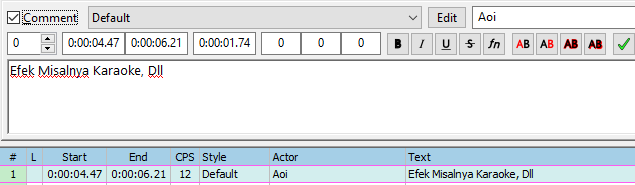

Dengan begitu, Anda bisa memastikan hanya dialog yang relevan yang akan dikirim ke AI.

### Langkah 1: Buka Notebook & Siapkan API Key

1.  Buka notebook ini di Google Colab.
2.  Siapkan API Key Gemini Anda. Cara paling aman adalah menggunakan fitur **Secrets** di Colab:
      * Klik ikon **kunci (🔑)** di sidebar kiri.
      * Klik **"Add a new secret"**.
      * **Name:** `GEMINI_API_KEY`
      * **Value:** Tempel API Key Anda di sini.
      * Nyalakan tombol **"Notebook access"**.

### Langkah 2: Jalankan Semua Sel

Jalankan sel-sel di notebook secara berurutan dari atas ke bawah, dimulai dari sel instalasi hingga sel terakhir yang akan meluncurkan aplikasi Gradio.

### Langkah 3: Gunakan Antarmuka Gradio

Setelah sel terakhir dijalankan, sebuah antarmuka web akan muncul. Gunakan URL publik yang tersedia untuk membukanya di tab baru.

1.  **Unggah File**: Klik dan pilih file `.ass` yang ingin Anda terjemahkan.
2.  **Atur Bahasa**: Tentukan bahasa sumber dan target.
3.  **Pilih Model**: Pilih model AI yang ingin digunakan. "2.0 Flash" direkomendasikan untuk pengguna gratis karena batas kuotanya lebih longgar.
4.  **Isi Konteks & Instruksi (Opsional)**: Berikan informasi tambahan kepada AI untuk hasil yang lebih baik.
5.  **Mulai Terjemahkan**: Klik tombolnya dan saksikan prosesnya berjalan secara real-time di sidebar log.
6.  **Unduh Hasil**: Setelah proses selesai, sebuah tombol unduh akan muncul secara otomatis.

## Perbandingan dengan Versi Lama (`Gemini-TXT-Translator`)

| Fitur                 | Gemini-TXT-Translator (Lama)                                             | AI Subtitle Translator (Baru)                                                              |
| :-------------------- | :----------------------------------------------------------------------- | :----------------------------------------------------------------------------------------- |
| **Proses Kerja** | Manual: Ekstrak dialog ke `.txt`, terjemahkan, lalu masukkan kembali.      | **Otomatis**: Unggah file `.ass`, terjemahkan, dan unduh file `.ass` yang sudah jadi.      |
| **Konteks Subtitle** | Semua timing, style, dan efek **hilang** saat diekstrak ke `.txt`.         | Semua timing, style, dan efek **100% terjaga**.                                            |
| **Efisiensi** | Menerjemahkan **baris per baris**, sangat lambat dan banyak panggilan API. | Menerjemahkan dalam **batch (100 baris)**, lebih cepat dan efisien.                        |
| **Feedback Proses** | Tidak ada. Hanya bisa menunggu hingga semua baris selesai.                | **Live Log**: Memberikan update status untuk setiap langkah.                               |
| **Antarmuka** | Tidak ada. Proses berbasis file manual.                                  | **Antarmuka Web Interaktif** dari Gradio.                                                  |

## Teknologi yang Digunakan

  * **Python**
  * **Google Generative AI (Gemini API)**
  * **Gradio**
  * **Google Colab**